In [1]:
import numpy as np
import matplotlib.pyplot as plt
from monte_carlo import *

## Monte Carlo Integration
Estimate multi-dimensional integral (over unit hypercube) by randomly sampling $N$ abscissas: 
$$ I = \int{d^dx \; f(x)} \approx  E = \frac{1}{N} \sum_{n=1}^{N}{f(x_n)} , $$
with equality for $N \rightarrow \infty $ (if the random process used to sample $x_n$ has a constant natural density). Define variance of a function $f$ as
$$ \sigma^2(f) = \int { d^dx \; (f(x)-I)^2 } .$$
Using this, the variance of the Monte Carlo estimate is
$$ 
\int { dx_1...dx_N \left( \frac{1}{N} \sum_{n=1}^N f(x_n)- I \right)^2 }
= \int { dx_1...dx_N \frac{1}{N^2} \sum_{n=1}^N \sum_{m=1}^N (f(x_n)- I)(f(x_m)- I) } 
= \int {dx_1...dx_N \frac{1}{N^2} \sum_n{(f(x_n)-I)^2}}
= \frac{\sigma(f)^2}{N},
$$
since for $n \neq m$ the integrals separate and clearly $\int{dx\;(f(x)-I)} = 0$. 

The variance can be estimated using the unbiased sample variance
$$ S^2 = \frac{1}{N-1} \sum_{n=1}^N{(f(x_n)-E)^2} = \frac{1}{N-1}\sum_n{f(x_n)^2 } - \frac{N}{N-1}E^2$$

In [2]:
# this will be useful later on to compare integration results from several MC methods
def compare_integration(f, true_value, methods,  Nmin=2, Nmax=200, Nstep=5, dim=1):
    """ Plot the exact value vs the estimates and errors of each method for various sample sizes. """
    Ns = list(range(Nmin, Nmax+1, Nstep))  # sample sizes
    samples_count = len(Ns)                # number of different sample sizes
    
    estimate = np.empty(samples_count)  # integral for each sample size
    error = np.empty(samples_count)     # error estimate for each sample size

    for method in methods:
        for i in range(samples_count):
            estimate[i], error[i] = method(f, Ns[i])
        print("{}\taverage (deviation * sqrt(N)): {}, average (error * sqrt(N)): {}".format(
                method.method_name, np.average(abs(estimate - true_value)*np.sqrt(Ns)), np.average(np.sqrt(Ns)*error)))
        
        # plot estimated integral with one-sigma error intervals
        plt.errorbar(Ns, estimate, yerr=error, fmt=".-", label=method.method_name)
    # plot true value
    plt.plot([Ns[0], Ns[-1]], [true_value, true_value], "-", label="exact value")
    # configure plot
    plt.grid()
    plt.legend(loc="best")

MC Plain	average (deviation * sqrt(N)): 0.4507402167703464, average (error * sqrt(N)): 0.4750094715681511


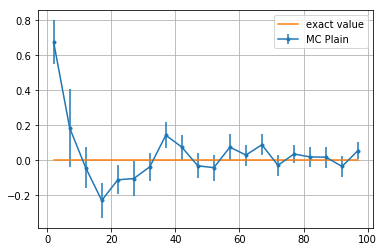

In [3]:
# simple example: sin(2 pi x)*sin(2 pi y). Integral over [0,1]^2 should give 0
def sin2d(x, y):
    # this factorizes to two sines, so we don't need to vectorize
    return np.sin(2*np.pi*x) * np.sin(2*np.pi*y)
    
compare_integration(sin2d, 0, Nmin=2, Nmax=100, methods=[MonteCarloPlain(2)])

MC Plain	average (deviation * sqrt(N)): 1.9562254875239564, average (error * sqrt(N)): 2.042187343119479


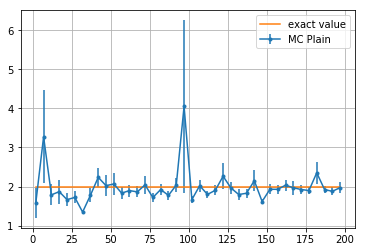

In [4]:
# f(x) = 1/sqrt(x) is integrable and MC converges to true value, but error estimate relied on square-integrability.
# the variance of f does not converge, which implies the estimate of this cannot yield a good error estimate
compare_integration(lambda x: 1/np.sqrt(x), 2, Nmax=200, Nstep=5, methods=[MonteCarloPlain()])

## Variance Reducing Techniques
The error in the MC estimate scales like $1/\sqrt{N}$, which constitutes a slow convergence. Improving this value is desirable.
### stratified sampling
Split $M=[0,1]^d$ into $k$ regions $M_j$, in each region perform MC with $N_j$ points. We obtain the estimate
$$ E = \sum_{j=1}^k {\frac{\text{vol}(M_j)}{N_j}} \sum_{n=1}^{N_j} {f(x_{jn})}, $$
and the variance of the MC estimate becomes
$$ 
\sum_{j=1}^k {\frac{\text{vol}(M_j)^2}{N_j} \left.\sigma^2(f)\right|_{M_j} }, \; \text{with} \;  
\left.\sigma^2(f)\right|_{M_j} = \frac{1}{\text{vol}(M_j)}\int_{M_j} {dx \left( f(x) - \frac{1}{\text{vol}(M_j)}\int_{M_j}{dx f(x)}  \right)^2}.
$$
Whether this method reduces or increases the variance depends on the choice of subspaces and respective point counts. It is obvious from the expression that to reduce the error/variance, regions with larger variance should have assigned larger $N_j$. Generally, for minimal variance the number of points must be chosen proportional to $\left.\sigma(f)\right|_{M_j}$.

In [5]:
# iterate and sample a 1D volume, divided into 2 regions, with doulbe weight on the second region (index (1,))
volumes = GridVolumes(dim=2, otherNs=1, Ns={(0,1):3}, divisions=2)

for N, sample, vol in volumes.iterate(1):
    print(N, vol)
    print(sample)

1 0.25
[[0.02831641 0.03508194]]
3 0.25
[[0.17199242 0.98549738]
 [0.17608829 0.6172231 ]
 [0.0823317  0.71186846]]
1 0.25
[[0.58389944 0.23638931]]
1 0.25
[[0.98950291 0.65406235]]


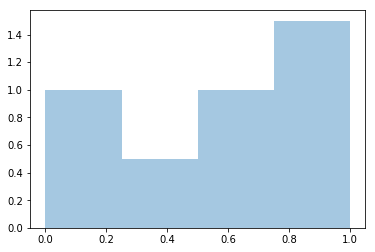

In [6]:
# Simple uniform grid
GridVolumes(divisions=4, dim=1, otherNs=2, Ns={(1,): 1, (3,):3}).plot_pdf()

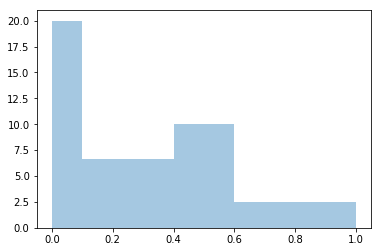

In [7]:
# Example of custom widths
GridVolumes(bounds=([0,.1,.4,.6,1],), Ns={(3,):1}, otherNs=2).plot_pdf()

MC Plain	average (deviation * sqrt(N)): 0.6535188064312452, average (error * sqrt(N)): 0.708909675390391
MC Stratified	average (deviation * sqrt(N)): 0.3095613865105912, average (error * sqrt(N)): 0.3578305435579702


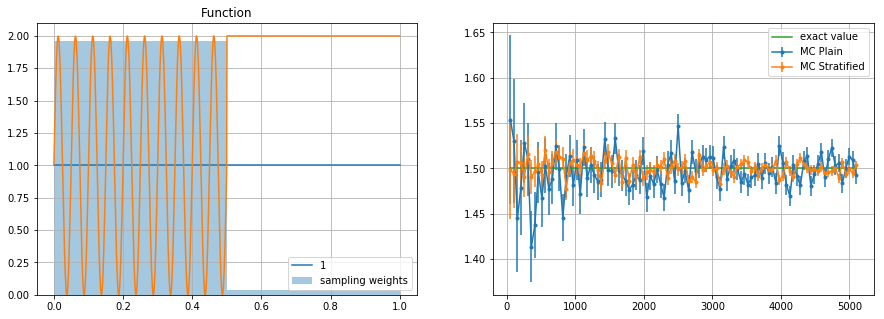

In [10]:
volumes = GridVolumes(divisions=2, otherNs=1, Ns={(0,):50})
half_sin = lambda x: (x<.5)*(1+np.sin(4*10*np.pi*x)) + (x>.5)*2
half_sin_integral = 1.5

# plot the function
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Function")
volumes.plot_pdf()
x = np.linspace(0,1,1000)
plt.plot(x, [1 for i in x], label="1")
plt.plot(x,half_sin(x))
plt.grid()
plt.legend()

# compare 
plt.subplot(122)
compare_integration(half_sin, half_sin_integral, Nmin=volumes.totalN, Nmax=volumes.totalN*100, Nstep=volumes.totalN, 
                    methods=[MonteCarloPlain(), MonteCarloStratified(volumes).get_interface_infer_multiple()])

plt.show()

In [11]:
# another nice plotting routine to compare predicted and actual errors of different methods/parameter choices
# for smoothing, average over given number of iterations
def compare_errors(f, true_value, iterations=1, Nmin=2, Nmax=100, Nstep=1, methods=[]):
    Ns = list(range(Nmin, Nmax+1, Nstep))  # sample sizes
    samples_count = len(Ns)                # number of different sample sizes
    
    errors = np.zeros(samples_count)
    ms = np.zeros(samples_count)
    for m in range(len(methods)):
        for i in range(samples_count):
            errors[i] = 0
            ms[i] = 0
            for j in range(iterations):
                val, err = methods[m](f, Ns[i])
                errors[i] += err/iterations
                ms[i] += (val-true_value)**2/iterations
                
        # plot average error
        plt.title("Errors, values scaled by $\\sqrt{N}$")
        plt.xlabel("N")
        plt.plot(Ns, errors*np.sqrt(Ns), ".-", label="%s predicted"%methods[m].method_name, color="C%d"%m)
        plt.plot(Ns, np.sqrt(ms)*np.sqrt(Ns), "--", label="%s rms deviation"%methods[m].method_name, color="C%d"%m)
        # configure plot
        plt.grid()
        plt.legend(loc="best")

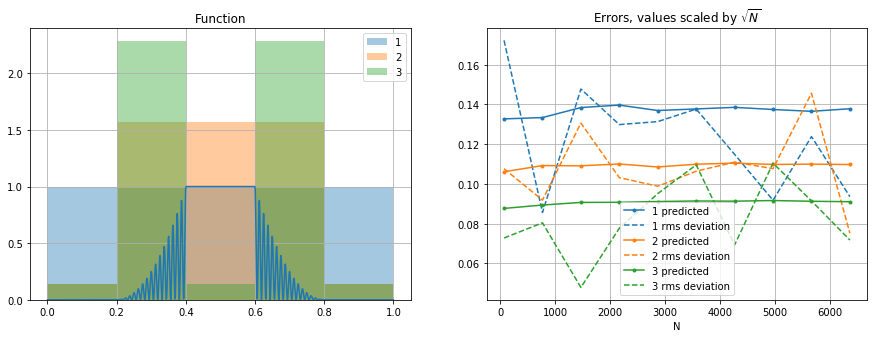

In [14]:
# on to a more compliated function to see how best to choose weights
tf_a = 16
tf_b = 1/.2**2
def osc(x):
    return x**2*np.cos(tf_a*np.pi*x/.2)**2*tf_b
def bound(a, x, b):
    return (x>a)*(x<=b)
def test_function(x):
    return bound(.2, x, .4)*osc(x-.2) + bound(.4, x, .6) + bound(.6, x, .8)*osc(.8-x)
test_function_true_value = 2*.0333531 + .2

# plot function and volume choices for stratified sampling
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Function")
x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
plt.grid()

vol1 = GridVolumes(divisions=5, otherNs=14)
vol2 = GridVolumes(divisions=5, otherNs=2, Ns={(1,):22, (3,):22, (2,):22})
vol3 = GridVolumes(divisions=5, otherNs=2, Ns={(1,):32, (3,):32})
vol1.plot_pdf("1")
vol2.plot_pdf("2")
vol3.plot_pdf("3")
plt.legend()

plt.subplot(122)

compare_errors(test_function, test_function_true_value, iterations=10, Nmin=vol1.totalN, Nmax=vol1.totalN*100, Nstep=vol1.totalN*10, 
                    methods=[MonteCarloStratified(vol1, "1").get_interface_infer_multiple(), 
                             MonteCarloStratified(vol2, "2").get_interface_infer_multiple(), 
                             MonteCarloStratified(vol3, "3").get_interface_infer_multiple()])
plt.show()

**Observation**: It is most important to increase sampling in regions where f varies quickly.

(Note: stratified sampling is substantially different from importance sampling, which is why for stratified sampling regions of large variance of f should have bigger weights, whereas for importance sampling the pdf should be as close to f as possible.
In stratified sampling each region is considered individually and therefore when f is large but constant small samples will be acceptable. If $p(x)$ in importance sampling is small in these regions, these large values of f would be underrepresented and (as they yield large values of $f(x)/p(x)$) increase the variance of the MC estimate.)

### importance sampling
Consider a change of variables
$$ \int {dx \; f(x)} = \int {\frac{f(x)}{p(x)} dx} = \int {\frac{f(x)}{p(x)} dP(x)} $$
with $$ p(x) = \frac{\partial^d}{\partial x_1 ... \partial x_d} P(x) .$$

Interpret $p(x)$ as a probability density with $p(x) \geq 0$ and normalized: $\int{dx\;p(x)} = 1$. If the $x_n$ are sampled from the corresponding distribution $P(x)$, we have
$$ E = \frac{1}{N} \sum_{n=1}^{N}{\frac{f(x_n)}{p(x_n)}}.$$
The variance of the MC estimate is (analogously to the first calculation)
$$ 
\int { dx_1...dx_N \; p(x_1)...p(x_N)\left( \frac{1}{N} \sum_{n=1}^N f(x_n)- I \right)^2 } 
= \frac{1}{N} \int {dx \; p(x) \left( \frac{f(x)}{p(x)} - I \right)^2 } = \frac{\sigma^2(f/p)}{N} \;,
$$
which may in turn be estimated by the sample variance, using E instead of I:
$$ 
\sigma^2\left(\frac{f}{p}\right) \approx S^2\left(\frac{f}{p}\right) 
= \frac{1}{N} \sum_{n=1}^N {\left(\frac{f(x_n)}{p(x_n)}\right)^2} - E^2 .
$$

Using $p$ which are (close to) zero where $f$ is not zero is dangerous as the variance diverges while the sample variance does not (appropriate regions are less likely to be sampled for small $p$).

MC Plain	average (deviation * sqrt(N)): 0.27886781756049733, average (error * sqrt(N)): 0.35388959876580983
MC Importance	average (deviation * sqrt(N)): 0.2815694727022692, average (error * sqrt(N)): 0.3533983026931042


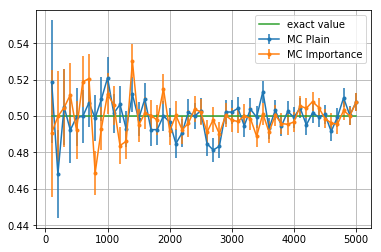

In [16]:
# with the default values (uniform distribution) monte carlo importance and plain monte carlo are exactly equivalent 
f = lambda x: np.sin(x*2*np.pi)**2
compare_integration(f, 1/2, Nmin=100, Nmax=5000, Nstep=100, 
                    methods=[MonteCarloPlain(), MonteCarloImportance()])

## Generating Samples from a Given Distribution
### Acceptance-Rejection method
We want to sample according to a pdf $p(x)$. We know another (similar) pdf $h(x)$ s.t. $p(x) \leq Ch(x)$ for some $C \geq 0$.
Then use the following algorithm:
1. sample $x$ according to $h$
2. generate random number $u \in [0,1]$ and accept $x$ if $p(x) \geq uCh(x)$, else reject and start over

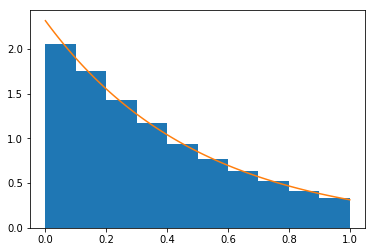

In [17]:
# 1D example
a = 2
p = lambda x: a/(1-np.exp(-a)) * np.exp(-a*x)  # want to sample according to this
acception_rejection = AcceptionRejection(p, 5)

plt.hist(acception_rejection(10000), bins=10, normed=True)
plt.plot(np.linspace(0,1,100), p(np.linspace(0,1,100)))

### Metropolis algorithm
The metropolis algorithm is a simple Markov chain that, in it's limit, generates the desired distribution.
It starts from a state $\phi$ and transitions to a new state $\phi'$.

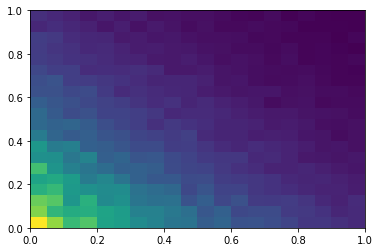

In [18]:
# test Metropolis
a = 2
p = lambda x: a**2/(1-np.exp(-a))**2 * np.exp(-a*x[0]-a*x[1])
metropolis = Metropolis(np.array([.5, .5]), p, dim=2)
rand = metropolis(100000).transpose()
_= plt.hist2d(rand[0], rand[1], bins=20, normed=True)

MC Plain	average (deviation * sqrt(N)): 0.31337777537317874, average (error * sqrt(N)): 0.3531034723134228
MC Importance	average (deviation * sqrt(N)): 0.021018975740439604, average (error * sqrt(N)): 0.029845070808591508


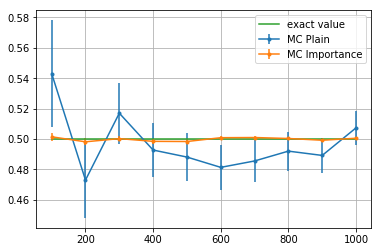

In [19]:
# Now apply distributions to importance sampling

# sin^2
f = lambda x: np.sin(x*2*np.pi)**2

p_ideal = lambda x: f(x+.005) / (1/2) # almost ideal
sampling = AcceptionRejection(p_ideal, 2) # max value of f is 1

compare_integration(f, 1/2, Nmin=100, Nmax=1000, Nstep=100, 
                    methods=[MonteCarloPlain(), MonteCarloImportance(sampling_fn=sampling, pdf=p_ideal)])

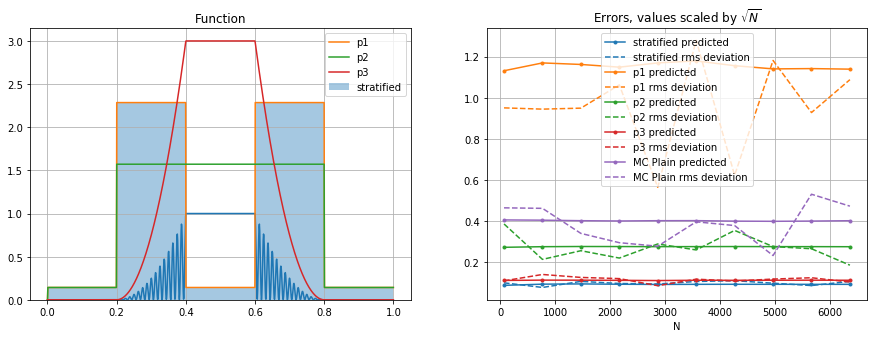

In [21]:
# use test_function and true_value from earlier

# compare importance sampling to the stratified boxing from before
vol = CubeVolumes(5, otherNs=2, Ns={(1,):32, (3,):32})
p1 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*32 + bound(.4,x,.6)*2 + bound(.6,x,.8)*32 + bound(.8,x,1)*2)/vol.totalN/.2
p2 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*22 + bound(.4,x,.6)*22 + bound(.6,x,.8)*22 + bound(.8,x,1)*2)/vol.totalN/.2
p3 = lambda x: (bound(.2,x,.4)*((x-.2)/.2)**2 + bound(.6,x,.8)*((.8-x)/.2)**2 + bound(.4,x,.6))/(.2 + .1333333)
sampling1 = AcceptionRejection(p1, 3)
sampling2 = AcceptionRejection(p2, 2)
sampling3 = AcceptionRejection(p3, 3.5)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Function")
x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
plt.grid()

plt.plot(x,p1(x), label="p1")
plt.plot(x,p2(x), label="p2")
plt.plot(x,p3(x), label="p3")
vol.plot_pdf("stratified")
plt.legend()

plt.subplot(122)
compare_errors(test_function, test_function_true_value, iterations=10, Nmin=vol1.totalN, Nmax=vol1.totalN*100, Nstep=vol1.totalN*10, 
               methods=[MonteCarloStratified(volumes=vol, name="stratified"),
                        MonteCarloImportance(sampling_fn=sampling1, pdf=p1, name="p1"),
                        MonteCarloImportance(sampling_fn=sampling2, pdf=p2, name="p2"),
                        MonteCarloImportance(sampling_fn=sampling3, pdf=p3, name="p3"),
                        MonteCarloPlain()])
plt.show()

## Adaptive Methods
### VEGAS Monte Carlo

In [22]:
# see if the equation for error estimate is reasonable
trueval = .25
f = lambda x: x[0]*x[1]
ms = 0
var_mean = 0
N = 1000
for i in range(N):
    vegas = MonteCarloVEGAS(dim=2, divisions=10)
    E, var = vegas(f, 100)
    ms += (E - trueval)**2 / N
    var_mean += var/N
print(np.sqrt(ms), var_mean)

0.02346761406993411 0.021790763104440346


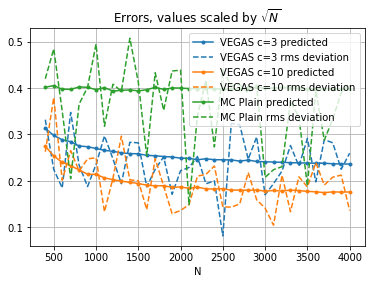

In [23]:
vegas3 = MonteCarloVEGAS(divisions=10, Nj=100, c=3, name="VEGAS c=3")
vegas5 = MonteCarloVEGAS(divisions=10, Nj=100, c=10, name="VEGAS c=10")
compare_errors(test_function, test_function_true_value, iterations=10, Nmin=400, Nmax=4000, Nstep=100,
               methods=[vegas3, vegas5, MonteCarloPlain()])

(0.2671578599925162, 0.0006139336304908526, 0.9372830246431642)


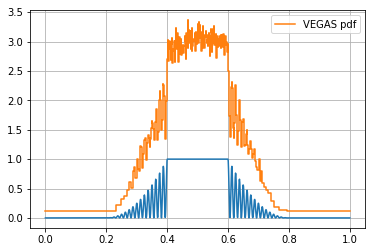

In [24]:
vegas = MonteCarloVEGAS(divisions=300, Nj=1000, c=400)
print(vegas(test_function, 50000, xhi=True))

x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
vegas.plot_pdf()
plt.legend()
plt.grid()

## Multi Channel Monte Carlo

In [2]:
# test channel sampling
channels = Channels([lambda N: np.random.rand(N*3).reshape(N,3), lambda N: np.random.rand(N*3).reshape(N,3)/2], 
                    [lambda *x: 1, lambda x, y, z: 2*(z<=.5)*(x<=.5)*(y<=.5)])
channels.generate_sample(1000)
np.add.reduceat(channels.samples, channels.sample_bounds)  / channels.sample_sizes[:, np.newaxis]

array([[0.46802709, 0.50666997, 0.50142737],
       [0.25391104, 0.25265686, 0.26217691]])

rms vs mean error
0.042161097884244075 0.039849999362907174


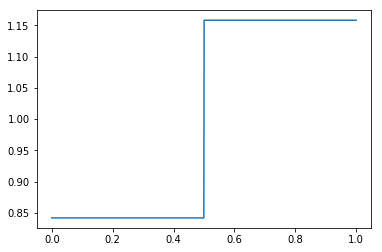

In [13]:
f = lambda x: test_function(x)
true_val = test_function_true_value
channels = Channels([np.random.rand, lambda N: np.random.rand(N)/2, lambda N: .5+np.random.rand(N)/2],
                    [lambda x: 1, lambda x: 2*(x<=.5), lambda x: 2*(x>.5)])
mcmci = MonteCarloMultiImportance(channels).get_interface_ratios(r1=0, r3=0, Nj=100)

ms = 0
err_mean = 0
N = 100
for i in range(N):
    E, err = mcmci(f, 100)
    ms += (E - true_val)**2 / N
    err_mean += err/N
print("rms vs mean error")
print(np.sqrt(ms), err_mean)
channels.plot_pdf()

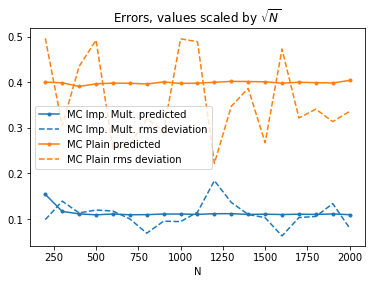

In [14]:
# use on test_function with the three probability distributions from before
p1 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*32 + bound(.4,x,.6)*2 + bound(.6,x,.8)*32 + bound(.8,x,1)*2)/70/.2
p2 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*22 + bound(.4,x,.6)*22 + bound(.6,x,.8)*22 + bound(.8,x,1)*2)/70/.2
p3 = lambda x: (bound(.2,x,.4)*((x-.2)/.2)**2 + bound(.6,x,.8)*((.8-x)/.2)**2 + bound(.4,x,.6))/(.2 + .1333333)
sampling1 = AcceptionRejection(p1, 3)
sampling2 = AcceptionRejection(p2, 2)
sampling3 = AcceptionRejection(p3, 3.5)
channels = Channels([sampling1, sampling2, sampling3], [p1, p2, p3])

mcmci = MonteCarloMultiImportance(channels).get_interface_ratios(Nj=100, r1=0, r2=.5, r3=.5)
compare_errors(test_function, test_function_true_value, Nmin=200, Nmax=2000, Nstep=100, iterations=10, 
               methods=[mcmci, MonteCarloPlain()])
plt.show()

-0.00412861326548436 0.002656371769224661


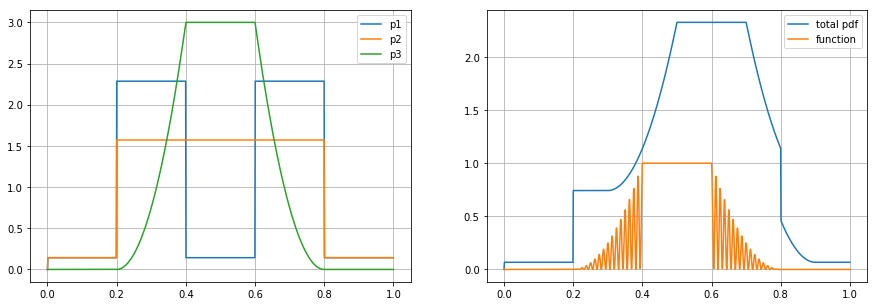

In [15]:
shift = .1
p3 = lambda x: (bound(.2,x,.4)*((x-.2)/.2)**2 + bound(.6,x,.8)*((.8-x)/.2)**2 + bound(.4,x,.6))/(.2 + .1333333)
sampling3_shifted = AcceptionRejection(lambda x: p3(x-shift), 3.5)
channels = Channels([sampling1, sampling2, sampling3_shifted], [p1, p2, lambda x: p3(x-shift)])
mcmci = MonteCarloMultiImportance(channels).get_interface_ratios(Nj=100, r1=.2, r2=.4, r3=.4)

plt.figure(figsize=(15,5))
plt.subplot(121)
x = np.linspace(0,1,1000)
plt.plot(x, p1(x), label="p1")
plt.plot(x, p2(x), label="p2")
plt.plot(x, p3(x), label="p3")
plt.grid()
plt.legend()

plt.subplot(122)
est, err = mcmci(test_function, 10000)
print(est-test_function_true_value, err)
channels.plot_pdf()
plt.plot(x,test_function(x), label="function")
plt.legend()
plt.grid()

plt.show()

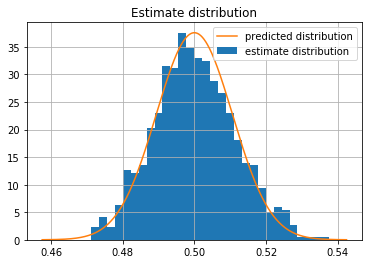

In [17]:
def compare_distribution(fn, true_val, N, iterations, method, bins=20):
    values = np.empty(iterations)
    mean_var = 0
    for i in range(iterations):
        values[i], var = method(fn, N)
        mean_var += var**2 / iterations
    plt.hist(values, bins=bins, normed=True, label="estimate distribution")
    x = np.linspace(true_val-4*np.sqrt(mean_var), true_val+4*np.sqrt(mean_var), 1000)
    plt.plot(x, np.exp(-(x-true_val)**2/2/mean_var) / np.sqrt(np.pi*2*mean_var), label="predicted distribution")
    plt.title("Estimate distribution")
    plt.grid()
    plt.legend(loc="best")
    
fn = lambda x: np.sin(2*np.pi*x)**2
channels = Channels([sampling1], [p1])
mcmci = MonteCarloMultiImportance(channels, var_weighted=False).get_interface_ratios(Nj=200, r1=0, r2=0, r3=1)
mcmci1 = MonteCarloImportance(1, sampling_fn=sampling1, pdf=p1)
# compare_distribution(fn, 0.5, 400, 1000, mcmci1, bins=30)
compare_distribution(fn, .5, 5000, 1000, mcmci, bins=30)

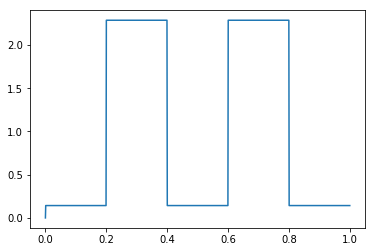

In [18]:
channels.plot_pdf()

# Sampling

### Importance Sampling
When, like in Importance Sampling Monte Carlo, there is a normalized pdf $g(x)$ approximating $f(x)$, the acception-rejection method can be used to generate values according to the $f$ distribution (where $f$ would be the non-normalized pdf). The AcceptionRejection class implements this.


## MCMCMC

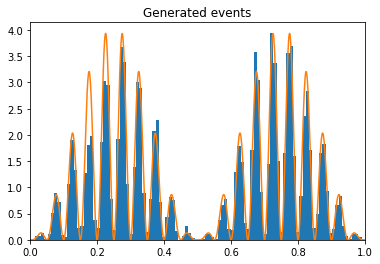

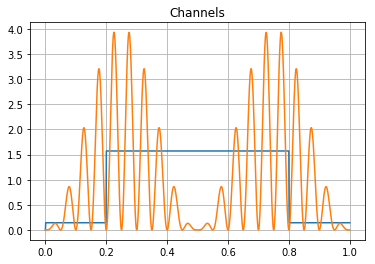

In [922]:
fn = lambda x: np.sin(2*np.pi*x)**2 * np.sin(10*2*np.pi*x)**2
mc3 = MC3(1, Channels([ sampling2, sampling3], [p2, p3]), fn, delta=.01, initial_value=.5)
res = mc3(([], [500]*40, []), 30000, beta=0.3)
# beta = 1: only importance sampling

plt.title("Generated events")
plt.hist(res, normed=True, bins=100)
plt.xlim(0, 1)
x = np.linspace(0, 1, 1000)
plt.plot(x, fn(x)/mc3.integral)
plt.show()

plt.title("Channels")
mc3.channels.plot_pdf()
plt.plot(x, fn(x)/mc3.integral)
plt.grid()
plt.show()